In [52]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import math

import sklearn
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [53]:
random_seed = 42424242
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

In [54]:
print('numpy: ', np.__version__)
print('pandas: ', pd.__version__)
print('scikit-learn: ', sklearn.__version__)
print('pytorch: ', torch.__version__)

numpy:  1.20.3
pandas:  1.3.2
scikit-learn:  0.24.2
pytorch:  1.9.0


In [112]:
cancer_type = 'intestine' # breast, intestine, lung
BATCH_SIZE = 8
learning_rate = 1e-7
EPOCHS = 100
device = torch.device('cuda:0')
device_cpu = torch.device('cpu')
save_path = './model/best_model.pt'

In [138]:
class CustomDataset(Dataset):
    def __init__(self, path, mode='train'):
        self.mode = mode
        self.data = pd.read_csv(path)
        self.length = len(np.array(self.data)[0, :])
        self.props = np.array(self.data.iloc[:, range(1, self.length-1)])
        
        if self.mode == 'train':
            self.labels = np.array(self.data.iloc[:, self.length-1])
            self.labels = self.labels / np.max(self.labels)
        
    def __len__(self):
        return len(self.props)
    
    def Max(self):
        return np.max(np.array(self.data.iloc[:, self.length-1]))
    
    def __getitem__(self, i):
        if self.mode == 'train':
            return {
                'props' : torch.tensor(self.props[i], dtype=torch.float32),
                'labels' : torch.tensor(self.labels[i], dtype=torch.float32)
            }
        else:
            return{
                'props' : torch.tensor(self.props[i], dtype=torch.float32)
            }

In [139]:
train_path = f'./train_{cancer_type}.csv'
val_path = f'./val_{cancer_type}.csv'

train_dataset = CustomDataset(train_path)
val_dataset = CustomDataset(val_path)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [140]:
train_dataset.Max()

1825

In [141]:
sample_batch = next(iter(train_dataloader))
sample_batch['labels']

tensor([0.0395, 0.3896, 0.0575, 0.5786, 0.3901, 0.1622, 0.0093, 0.0164])

In [142]:
sample_batch['props'].shape, sample_batch['labels'].shape

(torch.Size([8, 52]), torch.Size([8]))

In [143]:
sample_batch['props'].dtype, sample_batch['labels'].dtype

(torch.float32, torch.float32)

In [144]:
data_length = len(sample_batch['props'][1])

In [194]:
class MLP(nn.Module):
    def __init__(self, num):
        super(MLP, self).__init__()
        self.ln1 = nn.Linear(num, 20, bias=True)
        nn.init.xavier_normal_(self.ln1.weight)
        self.ln2 = nn.Linear(20, 1, bias=True)
        nn.init.xavier_normal_(self.ln2.weight)
        self.dropout = nn.Dropout(0.4)
        
    def forward(self, x):
        x = self.ln1(x)
        x = nn.LeakyReLU()(x)
        x = self.ln2(x)
        output = nn.Sigmoid()(x)
        return output

In [190]:
model = MLP(data_length).to(device)

In [191]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [192]:
def train_step(batch_item, epoch, batch, training):
    props = batch_item['props'].to(device)
    labels = batch_item['labels'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(props)
            loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        return loss
    
    else:
        model.eval()
        with torch.no_grad():
            output = model(props)
            loss = criterion(output, labels)
            
        return loss

In [193]:
loss_plot, val_loss_plot = [], []

for epoch in range(EPOCHS):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = enumerate(tqdm(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
    print('Epoch : {}, Loss: {:03f}, Total Loss : {:03f}'.format(epoch+1, batch_loss.item(), total_loss/(batch+1)))

    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = enumerate(tqdm(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
    print('Epoch : {}, Val_Loss: {:03f}, Total Val_Loss : {:03f}'.format(epoch+1, batch_loss.item(), total_loss/(batch+1)))
        
    val_loss_plot.append(total_val_loss/(batch+1))

    if np.min(torch.tensor(val_loss_plot).to(device_cpu).numpy()) == val_loss_plot[-1]:
        torch.save(model, save_path)

  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 1, Loss: 0.553834, Total Loss : 0.553674


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 1, Val_Loss: 0.588636, Total Val_Loss : 1.107347


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 2, Loss: 0.610670, Total Loss : 0.553622


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 2, Val_Loss: 0.482856, Total Val_Loss : 1.107244


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 3, Loss: 0.615400, Total Loss : 0.553547


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 3, Val_Loss: 0.610171, Total Val_Loss : 1.107093


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 4, Loss: 0.589370, Total Loss : 0.553666


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 4, Val_Loss: 0.641276, Total Val_Loss : 1.107332


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 5, Loss: 0.548641, Total Loss : 0.553593


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 5, Val_Loss: 0.458002, Total Val_Loss : 1.107186


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 6, Loss: 0.443024, Total Loss : 0.553692


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 6, Val_Loss: 0.700123, Total Val_Loss : 1.107385


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 7, Loss: 0.594312, Total Loss : 0.553578


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 7, Val_Loss: 0.457279, Total Val_Loss : 1.107157


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 8, Loss: 0.441917, Total Loss : 0.553536


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 8, Val_Loss: 0.594641, Total Val_Loss : 1.107071


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 9, Loss: 0.568186, Total Loss : 0.553583


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 9, Val_Loss: 0.654155, Total Val_Loss : 1.107166


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 10, Loss: 0.375167, Total Loss : 0.553555


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 10, Val_Loss: 0.598164, Total Val_Loss : 1.107109


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 11, Loss: 0.521015, Total Loss : 0.553527


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 11, Val_Loss: 0.619448, Total Val_Loss : 1.107054


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 12, Loss: 0.591649, Total Loss : 0.553574


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 12, Val_Loss: 0.523837, Total Val_Loss : 1.107149


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 13, Loss: 0.635345, Total Loss : 0.553527


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 13, Val_Loss: 0.551340, Total Val_Loss : 1.107053


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 14, Loss: 0.553802, Total Loss : 0.553492


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 14, Val_Loss: 0.443069, Total Val_Loss : 1.106984


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 15, Loss: 0.336884, Total Loss : 0.553584


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 15, Val_Loss: 0.584117, Total Val_Loss : 1.107168


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 16, Loss: 0.518705, Total Loss : 0.553420


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 16, Val_Loss: 0.523485, Total Val_Loss : 1.106839


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 17, Loss: 0.463073, Total Loss : 0.553344


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 17, Val_Loss: 0.617670, Total Val_Loss : 1.106687


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 18, Loss: 0.482490, Total Loss : 0.553390


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 18, Val_Loss: 0.232875, Total Val_Loss : 1.106780


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 19, Loss: 0.702451, Total Loss : 0.553452


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 19, Val_Loss: 0.760979, Total Val_Loss : 1.106905


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 20, Loss: 0.571232, Total Loss : 0.553253


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 20, Val_Loss: 0.528051, Total Val_Loss : 1.106507


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 21, Loss: 0.473464, Total Loss : 0.553325


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 21, Val_Loss: 0.737567, Total Val_Loss : 1.106649


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 22, Loss: 0.495288, Total Loss : 0.553297


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 22, Val_Loss: 0.690775, Total Val_Loss : 1.106594


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 23, Loss: 0.464471, Total Loss : 0.553263


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 23, Val_Loss: 0.495819, Total Val_Loss : 1.106526


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 24, Loss: 0.469255, Total Loss : 0.553224


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 24, Val_Loss: 0.530035, Total Val_Loss : 1.106449


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 25, Loss: 0.322619, Total Loss : 0.553209


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 25, Val_Loss: 0.536392, Total Val_Loss : 1.106418


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 26, Loss: 0.762384, Total Loss : 0.553246


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 26, Val_Loss: 0.287777, Total Val_Loss : 1.106493


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 27, Loss: 0.677925, Total Loss : 0.553095


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 27, Val_Loss: 0.586946, Total Val_Loss : 1.106189


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 28, Loss: 0.775627, Total Loss : 0.553247


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 28, Val_Loss: 0.454882, Total Val_Loss : 1.106493


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 29, Loss: 0.659735, Total Loss : 0.553145


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 29, Val_Loss: 0.719676, Total Val_Loss : 1.106290


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 30, Loss: 0.532967, Total Loss : 0.553210


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 30, Val_Loss: 0.446032, Total Val_Loss : 1.106420


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 31, Loss: 0.687944, Total Loss : 0.553068


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 31, Val_Loss: 0.439780, Total Val_Loss : 1.106136


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 32, Loss: 0.619037, Total Loss : 0.553019


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 32, Val_Loss: 0.596579, Total Val_Loss : 1.106037


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 33, Loss: 0.316148, Total Loss : 0.553093


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 33, Val_Loss: 0.639439, Total Val_Loss : 1.106186


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 34, Loss: 0.482552, Total Loss : 0.553009


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 34, Val_Loss: 0.529741, Total Val_Loss : 1.106019


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 35, Loss: 0.656894, Total Loss : 0.552979


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 35, Val_Loss: 0.566988, Total Val_Loss : 1.105959


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 36, Loss: 0.739967, Total Loss : 0.552932


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 36, Val_Loss: 0.493203, Total Val_Loss : 1.105863


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 37, Loss: 0.665223, Total Loss : 0.552977


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 37, Val_Loss: 0.587702, Total Val_Loss : 1.105954


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 38, Loss: 0.530211, Total Loss : 0.552908


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 38, Val_Loss: 0.548943, Total Val_Loss : 1.105817


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 39, Loss: 0.474069, Total Loss : 0.553087


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 39, Val_Loss: 0.506543, Total Val_Loss : 1.106175


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 40, Loss: 0.563783, Total Loss : 0.552921


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 40, Val_Loss: 0.563661, Total Val_Loss : 1.105843


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 41, Loss: 0.438393, Total Loss : 0.552874


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 41, Val_Loss: 0.564265, Total Val_Loss : 1.105748


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 42, Loss: 0.515389, Total Loss : 0.552772


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 42, Val_Loss: 0.429620, Total Val_Loss : 1.105543


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 43, Loss: 0.663624, Total Loss : 0.552787


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 43, Val_Loss: 0.532066, Total Val_Loss : 1.105574


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 44, Loss: 0.582222, Total Loss : 0.552817


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 44, Val_Loss: 0.649833, Total Val_Loss : 1.105634


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 45, Loss: 0.467285, Total Loss : 0.552666


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 45, Val_Loss: 0.562476, Total Val_Loss : 1.105332


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 46, Loss: 0.560812, Total Loss : 0.552644


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 46, Val_Loss: 0.374761, Total Val_Loss : 1.105288


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 47, Loss: 0.501342, Total Loss : 0.552585


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 47, Val_Loss: 0.368482, Total Val_Loss : 1.105170


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 48, Loss: 0.520175, Total Loss : 0.552544


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 48, Val_Loss: 0.710597, Total Val_Loss : 1.105088


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 49, Loss: 0.411431, Total Loss : 0.552607


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 49, Val_Loss: 0.588820, Total Val_Loss : 1.105214


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 50, Loss: 0.711044, Total Loss : 0.552529


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 50, Val_Loss: 0.458165, Total Val_Loss : 1.105057


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 51, Loss: 0.712818, Total Loss : 0.552584


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 51, Val_Loss: 0.587371, Total Val_Loss : 1.105168


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 52, Loss: 0.574802, Total Loss : 0.552406


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 52, Val_Loss: 0.460546, Total Val_Loss : 1.104812


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 53, Loss: 0.720720, Total Loss : 0.552346


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 53, Val_Loss: 0.601074, Total Val_Loss : 1.104693


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 54, Loss: 0.627115, Total Loss : 0.552469


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 54, Val_Loss: 0.568804, Total Val_Loss : 1.104938


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 55, Loss: 0.664091, Total Loss : 0.552343


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 55, Val_Loss: 0.561970, Total Val_Loss : 1.104686


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 56, Loss: 0.678532, Total Loss : 0.552310


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 56, Val_Loss: 0.482345, Total Val_Loss : 1.104620


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 57, Loss: 0.817849, Total Loss : 0.552305


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 57, Val_Loss: 0.565257, Total Val_Loss : 1.104609


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 58, Loss: 0.547933, Total Loss : 0.552283


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 58, Val_Loss: 0.604995, Total Val_Loss : 1.104566


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 59, Loss: 0.382442, Total Loss : 0.552182


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 59, Val_Loss: 0.497807, Total Val_Loss : 1.104365


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 60, Loss: 0.522522, Total Loss : 0.552121


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 60, Val_Loss: 0.543102, Total Val_Loss : 1.104241


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 61, Loss: 0.415648, Total Loss : 0.552131


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 61, Val_Loss: 0.462431, Total Val_Loss : 1.104262


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 62, Loss: 0.513620, Total Loss : 0.552031


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 62, Val_Loss: 0.625664, Total Val_Loss : 1.104063


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 63, Loss: 0.625879, Total Loss : 0.552112


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 63, Val_Loss: 0.645521, Total Val_Loss : 1.104225


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 64, Loss: 0.644938, Total Loss : 0.552020


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 64, Val_Loss: 0.473944, Total Val_Loss : 1.104040


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 65, Loss: 0.592300, Total Loss : 0.551868


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 65, Val_Loss: 0.575484, Total Val_Loss : 1.103736


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 66, Loss: 0.728294, Total Loss : 0.551912


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 66, Val_Loss: 0.622962, Total Val_Loss : 1.103824


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 67, Loss: 0.518478, Total Loss : 0.551848


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 67, Val_Loss: 0.474832, Total Val_Loss : 1.103695


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 68, Loss: 0.489263, Total Loss : 0.551792


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 68, Val_Loss: 0.587320, Total Val_Loss : 1.103584


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 69, Loss: 0.529231, Total Loss : 0.551710


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 69, Val_Loss: 0.656918, Total Val_Loss : 1.103420


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 70, Loss: 0.563599, Total Loss : 0.551709


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 70, Val_Loss: 0.462720, Total Val_Loss : 1.103417


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 71, Loss: 0.517528, Total Loss : 0.551664


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 71, Val_Loss: 0.559067, Total Val_Loss : 1.103327


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 72, Loss: 0.446502, Total Loss : 0.551562


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 72, Val_Loss: 0.518746, Total Val_Loss : 1.103124


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 73, Loss: 0.775559, Total Loss : 0.551523


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 73, Val_Loss: 0.598653, Total Val_Loss : 1.103047


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 74, Loss: 0.519808, Total Loss : 0.551447


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 74, Val_Loss: 0.581626, Total Val_Loss : 1.102894


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 75, Loss: 0.542401, Total Loss : 0.551445


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 75, Val_Loss: 0.344562, Total Val_Loss : 1.102889


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 76, Loss: 0.519049, Total Loss : 0.551463


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 76, Val_Loss: 0.450786, Total Val_Loss : 1.102927


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 77, Loss: 0.682449, Total Loss : 0.551159


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 77, Val_Loss: 0.516219, Total Val_Loss : 1.102319


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 78, Loss: 0.624318, Total Loss : 0.551311


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 78, Val_Loss: 0.819201, Total Val_Loss : 1.102622


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 79, Loss: 0.679787, Total Loss : 0.551264


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 79, Val_Loss: 0.483521, Total Val_Loss : 1.102529


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 80, Loss: 0.594705, Total Loss : 0.551212


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 80, Val_Loss: 0.515381, Total Val_Loss : 1.102424


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 81, Loss: 0.632756, Total Loss : 0.551052


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 81, Val_Loss: 0.508622, Total Val_Loss : 1.102103


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 82, Loss: 0.543324, Total Loss : 0.550985


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 82, Val_Loss: 0.640090, Total Val_Loss : 1.101969


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 83, Loss: 0.704175, Total Loss : 0.550981


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 83, Val_Loss: 0.461943, Total Val_Loss : 1.101962


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 84, Loss: 0.473090, Total Loss : 0.550871


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 84, Val_Loss: 0.599565, Total Val_Loss : 1.101742


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 85, Loss: 0.509570, Total Loss : 0.550710


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 85, Val_Loss: 0.469036, Total Val_Loss : 1.101420


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 86, Loss: 0.628415, Total Loss : 0.550754


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 86, Val_Loss: 0.524932, Total Val_Loss : 1.101508


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 87, Loss: 0.676459, Total Loss : 0.550605


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 87, Val_Loss: 0.619442, Total Val_Loss : 1.101210


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 88, Loss: 0.584536, Total Loss : 0.550514


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 88, Val_Loss: 0.510282, Total Val_Loss : 1.101028


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 89, Loss: 0.466826, Total Loss : 0.550456


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 89, Val_Loss: 0.694810, Total Val_Loss : 1.100912


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 90, Loss: 0.769078, Total Loss : 0.550568


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 90, Val_Loss: 0.589477, Total Val_Loss : 1.101135


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 91, Loss: 0.429362, Total Loss : 0.550276


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 91, Val_Loss: 0.742752, Total Val_Loss : 1.100551


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 92, Loss: 0.499162, Total Loss : 0.550077


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 92, Val_Loss: 0.325646, Total Val_Loss : 1.100155


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 93, Loss: 0.534782, Total Loss : 0.550300


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 93, Val_Loss: 0.480082, Total Val_Loss : 1.100600


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 94, Loss: 0.711795, Total Loss : 0.550093


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 94, Val_Loss: 0.546548, Total Val_Loss : 1.100185


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 95, Loss: 0.539451, Total Loss : 0.550026


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 95, Val_Loss: 0.641551, Total Val_Loss : 1.100053


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 96, Loss: 0.285062, Total Loss : 0.550017


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 96, Val_Loss: 0.527903, Total Val_Loss : 1.100034


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 97, Loss: 0.435635, Total Loss : 0.549842


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 97, Val_Loss: 0.335379, Total Val_Loss : 1.099683


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 98, Loss: 0.545236, Total Loss : 0.549668


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 98, Val_Loss: 0.543536, Total Val_Loss : 1.099337


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 99, Loss: 0.618170, Total Loss : 0.549610


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 99, Val_Loss: 0.466926, Total Val_Loss : 1.099220


  0%|          | 0/1250 [00:00<?, ?it/s]

Epoch : 100, Loss: 0.349960, Total Loss : 0.549459


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch : 100, Val_Loss: 0.607839, Total Val_Loss : 1.098917


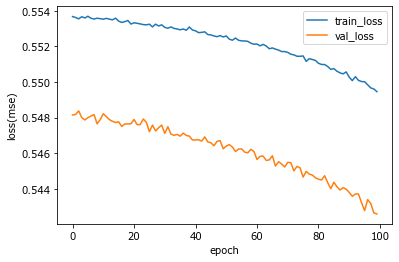

In [195]:
loss_plot_tensor = torch.tensor(loss_plot).to(device_cpu)
val_loss_plot_tensor = torch.tensor(val_loss_plot).to(device_cpu)
loss_plot = loss_plot_tensor.numpy()
val_loss_plot = val_loss_plot_tensor.numpy()

plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mse)')
plt.legend()
plt.show()

In [196]:
loss_plot

array([0.5536736 , 0.55362177, 0.55354667, 0.5536662 , 0.5535932 ,
       0.55369234, 0.5535785 , 0.55353564, 0.553583  , 0.5535547 ,
       0.553527  , 0.5535744 , 0.5535265 , 0.5534921 , 0.5535839 ,
       0.5534196 , 0.5533437 , 0.55338985, 0.5534523 , 0.5532534 ,
       0.55332464, 0.553297  , 0.55326295, 0.55322427, 0.5532092 ,
       0.5532464 , 0.55309474, 0.55324656, 0.5531448 , 0.55320984,
       0.5530682 , 0.5530186 , 0.5530928 , 0.5530094 , 0.5529794 ,
       0.55293167, 0.5529768 , 0.5529084 , 0.55308735, 0.5529214 ,
       0.55287385, 0.5527716 , 0.552787  , 0.5528168 , 0.5526662 ,
       0.55264395, 0.5525852 , 0.55254406, 0.55260706, 0.5525286 ,
       0.552584  , 0.55240595, 0.5523463 , 0.5524688 , 0.5523432 ,
       0.5523098 , 0.5523046 , 0.5522832 , 0.55218244, 0.5521207 ,
       0.5521312 , 0.5520314 , 0.55211234, 0.5520198 , 0.5518678 ,
       0.551912  , 0.5518475 , 0.55179214, 0.55171   , 0.5517087 ,
       0.55166364, 0.55156225, 0.5515233 , 0.5514468 , 0.55144

In [197]:
model = torch.load(save_path)

In [198]:
test_dataset = CustomDataset(val_path, mode='test')
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [199]:
maximum = test_dataset.Max()
maximum

1825

In [203]:
def predict(dataset):
    model.eval()
    result = []
    for batch_item in dataset:
        props = batch_item['props'].to(device)
        with torch.no_grad():
            output = model(props)
            print(output)
            output = torch.round(output * maximum)
        output = output.cpu().numpy()
        result.extend(list(output))
        
    return result

In [204]:
pred = predict(test_dataloader)

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9849],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.3049],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [0.9999],
        [0.9999],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1

tensor([[1.0000],
        [1.0000],
        [0.9999],
        [0.9978],
        [1.0000],
        [0.9283],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [0.8654],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9982],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.7434],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [0.9827],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9999]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [0.8602],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [0

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9999],
        [0.9995],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9998]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.2405],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9999],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [0.9999],
        [1.0000],
        [1.0000],
        [0.8372],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [0.9999],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [0.9886],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.0069],
        [1.0000]], device='cuda:0')
tensor([[0.8055],
        [1.0000],
        [1.0000],
        [0.9995],
        [1.0000],
        [0.9738],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [0.9969],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.0548]], device='cuda:0')
tensor([[0.9942],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [0.9999],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9983]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9822],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [0.9999],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
      

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [0.8837],
        [1.0000],
        [1.0000],
        [0.9481],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.4419],
        [1.0000],
        [0.9997]], device='cuda:0')
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0')
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [0.9999],
        [1.0000]], device='cuda:0')
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
tensor([[1.0000],
        [0.1248],
        [1.0000],
        [1.0000],
        [0.4726],
  

In [205]:
pred_df = pd.DataFrame(pred, columns=['Survival period'])
pred_df.to_csv('./Survival_period.csv')
pred_df

Survival period
0              1825.0
1              1825.0
2              1825.0
3              1825.0
4              1825.0
...               ...
4995           1825.0
4996           1825.0
4997           1825.0
4998           1690.0
4999           1825.0

[5000 rows x 1 columns]

In [187]:
val_label = pd.read_csv(val_path)['Survival period']
val_label

0        161
1        393
2        821
3        587
4        255
        ... 
4995    1397
4996    1093
4997      69
4998      30
4999     120
Name: Survival period, Length: 5000, dtype: int64

In [188]:
SE = 0
for i in range(len(val_label)):
    SE+=math.sqrt((pred_df.iloc[i] - val_label.iloc[i])**2)

print(SE/len(val_label))

2154.526661738345


In [164]:
np.array(pred_df).shape, np.array(val_label).shape

((5000, 1), (5000,))